Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 8657 images to process.


Processing images: 100%|██████████| 8657/8657 [50:07<00:00,  2.88it/s]


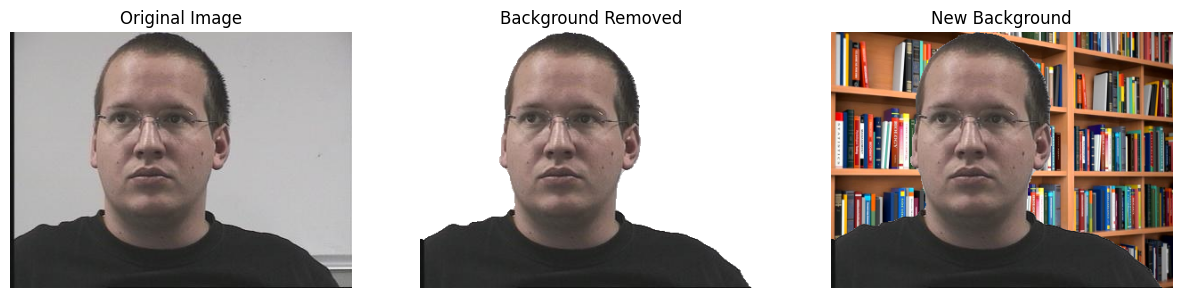

In [ ]:
# Install Mediapipe if not already installed (run in Google Colab or locally with pip)
!pip install mediapipe

# Import required libraries
import cv2
import mediapipe as mp
import numpy as np
import os
import shutil
from google.colab import drive  # Remove this if not using Google Colab
from tqdm import tqdm
import matplotlib.pyplot as plt

# Mount Google Drive to access files (remove this section if not using Google Colab)
drive.mount('/content/drive')

# Define paths and settings
input_folder = '/content/drive/MyDrive/Master_Thacsi/HeadPoseMixed'  # Update to your input folder path
output_folder = '/content/drive/MyDrive/Master_Thacsi/HeadPoseMixed_output'  # Update to your output folder path
bg_image_path = '/content/drive/MyDrive/Master_Thacsi/newbackground.jpg'  # Set to None for solid color, or update path
new_bg_color = (255, 255, 255)  # Solid color for new background in BGR (e.g., white) if no image

# Load custom background image if specified
if bg_image_path is not None:
    bg_image = cv2.imread(bg_image_path)
    if bg_image is None:
        print(f'Error: Could not load background image from {bg_image_path}')
        bg_image = None
else:
    bg_image = None

# Initialize MediaPipe Selfie Segmentation
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=0)  # 0 for general use
threshold = 0.5  # Confidence threshold for segmentation mask

# Collect all image files from input folder recursively
image_files = []
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            image_files.append(os.path.join(root, file))

print(f'Found {len(image_files)} images to process.')

# Process each image
for image_file in tqdm(image_files, desc="Processing images"):
    try:
        # Calculate relative path for subfolder structure
        relative_path = os.path.relpath(os.path.dirname(image_file), input_folder)
        # Define output subfolder (mirrors input structure)
        output_subfolder = os.path.join(output_folder, relative_path)
        os.makedirs(output_subfolder, exist_ok=True)

        # Define output paths
        file_name, ext = os.path.splitext(os.path.basename(image_file))
        original_output_path = os.path.join(output_subfolder, file_name + ext)
        nobg_output_path = os.path.join(output_subfolder, f"{file_name}_background_removed.png")
        newbg_output_path = os.path.join(output_subfolder, f"{file_name}_new_background.png")

        # Copy original image to output folder
        shutil.copy(image_file, original_output_path)

        # Load the input image
        image = cv2.imread(image_file)
        if image is None:
            print(f'Error: Could not read {image_file}')
            continue

        # Get image dimensions
        height, width, _ = image.shape

        # Convert image to RGB for MediaPipe
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Generate segmentation mask
        results = selfie_segmentation.process(image_rgb)
        mask = (results.segmentation_mask > threshold).astype(np.uint8)

        # Create boolean mask for foreground
        foreground_mask = mask == 1

        # 1. Create Image with Background Removed (transparent)
        nobg_image = np.zeros((height, width, 4), dtype=np.uint8)
        nobg_image[foreground_mask, :3] = image[foreground_mask]
        nobg_image[foreground_mask, 3] = 255  # Alpha channel: 255 for foreground
        cv2.imwrite(nobg_output_path, nobg_image)

        # 2. Create Image with New Background
        if bg_image is not None:
            resized_bg = cv2.resize(bg_image, (width, height))
        else:
            resized_bg = np.full((height, width, 3), new_bg_color, dtype=np.uint8)
        newbg_image = resized_bg.copy()
        newbg_image[foreground_mask] = image[foreground_mask]
        cv2.imwrite(newbg_output_path, newbg_image)

    except Exception as e:
        print(f'Error processing {image_file}: {e}')

# Display a sample result (optional)
if image_files:
    sample_image_file = image_files[0]
    relative_path = os.path.relpath(os.path.dirname(sample_image_file), input_folder)
    sample_original_file = os.path.join(output_folder, relative_path, os.path.basename(sample_image_file))
    file_name, _ = os.path.splitext(os.path.basename(sample_image_file))
    sample_nobg_file = os.path.join(output_folder, relative_path, f"{file_name}_background_removed.png")
    sample_newbg_file = os.path.join(output_folder, relative_path, f"{file_name}_new_background.png")

    sample_original = cv2.imread(sample_original_file)
    sample_nobg = cv2.imread(sample_nobg_file, cv2.IMREAD_UNCHANGED)  # Load with alpha channel
    sample_newbg = cv2.imread(sample_newbg_file)

    if all(img is not None for img in [sample_original, sample_nobg, sample_newbg]):
        # Convert to RGB for display
        sample_original_rgb = cv2.cvtColor(sample_original, cv2.COLOR_BGR2RGB)

        # Handle transparent background-removed image
        if sample_nobg.shape[2] == 4:  # Check for alpha channel
            alpha = sample_nobg[:, :, 3] / 255.0
            sample_nobg_rgb = cv2.cvtColor(sample_nobg[:, :, :3], cv2.COLOR_BGR2RGB)
            white_bg = np.ones_like(sample_nobg_rgb) * 255
            sample_nobg_display = (sample_nobg_rgb * alpha[:, :, np.newaxis] +
                                   white_bg * (1 - alpha[:, :, np.newaxis])).astype(np.uint8)
        else:
            sample_nobg_display = cv2.cvtColor(sample_nobg, cv2.COLOR_BGR2RGB)

        sample_newbg_rgb = cv2.cvtColor(sample_newbg, cv2.COLOR_BGR2RGB)

        # Display images
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(sample_original_rgb)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(sample_nobg_display)
        plt.title('Background Removed')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(sample_newbg_rgb)
        plt.title('New Background')
        plt.axis('off')
        plt.show()
    else:
        print('Error: Could not load sample images for display.')
else:
    print('No images found in the input folder.')